# Modeling Notebook
This notebook is meant to follow the [EDA notebook](eda.ipynb). In the previous notebook I preformed initial exploration and summary analysis of the data set being used in this project. In this notebook I will build a convolutional neural network using Keras. I will begin with a baseline model and attempt to improve using various methods including hyperparameter tuning, network regularization, and modifying the network architecture. 

## Data visualization
Below are two funcitons, visualize_training() and evaluate_model_performance(). The  former visualizes select KPIs and how they evolve across training epochs. The latter prints a SciKit-Learn classification report of the performance of the model's final evolution along with a plot of a confusion matrix showing the model's predictive preformance on a single batch of data; this function can be re-run in the same cell as many times as you'd like if you want to see several different batches. 

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

In [2]:
# visualizes accuracy and loss accross training epochs

def visualize_training(model_history,recall_num:None):
    """ 
    Visualizes the model's accuracy, loss, and recall as it evolves through training epochs.
    Training data is represented as a dot plot while test data is visualized as a line plot
    Takes two positional arguments:
        - a model history object 
        - a suffix generated by keras as a string (i.e. "_int")
            running this notebook sequentially without rerunning cells where models are compiled should allow for cells wher this function
            is called to be run as is. However if there is an error, check that this parameter is the same suffix as that used in the verbose
            print out from the cell where the relevant model is trained (i.e. some_model_results = some_model.fit()). This suffix is contained
            in memory and is an artifact of what order the model was compiled relative to the others in the active kernal, meaning if the kernal 
            is reset, so are these suffixes.     
    """
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    recall = model_history.history['recall'+recall_num]
    val_recall = model_history.history['val_recall'+recall_num]
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')

    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Test loss')
    plt.title('Training and Test loss')

    plt.legend()
    plt.figure()

    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Test recall')
    plt.title('Training and Test recall')

    plt.legend()
    plt.show()

In [3]:
# visualize confusion matrix of model's performance on a single batch of data (recommended to use test_data_generator)

def evaluate_model_performance(model,data_generator,verbose=True):
    """
    Takes in a keras model object and ImageDataGenerator object
    Samples a batch from the data generator
    Calcultes key performance indicators (KPIs)
    Prints loss and classification_report, and plots a confusion matrix
    If not verbose, returns loss, classification_report and confusion_matrix
    """
    
    # declare evaluation sample
    X_test, y_test = data_generator.next()

    # insantiate test prediction
    y_pred = np.round(model.predict(X_test))

    # evaluate KPIs
    eval = model.evaluate(X_test,y_test)

    # calculate the confusion matrix and classification report
    matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test,y_pred)

    # create a ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(matrix)

    # design plot aesthetics
    plot_color_list = ["lightblue","blue","orange","yellow"]
    plot_cmap = colors.ListedColormap(plot_color_list) 
    # plot the confusion matrix, print the classification report
    plt.matshow(matrix,cmap=plot_cmap)

    # Add a color bar to the plot
    plt.colorbar()

    # Add labels to the quadrants
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(x=j, y=i, s=matrix[i, j], ha="center", va="center")

    # Add axis labels
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Display the plot
    print(report)
    plt.show()


## Generate Data
For ease of portability, and because the data set comes pre-split for training and validation this notebook will utilize ImageDataGenerator objects for the train, test, and validation samples. Because it is common practice with image classification, the ImageDataGenerator use the rescale parameter to normalize the pixel data upon instantiation of the object. flow_from_directory is then used to infact generate the data from jpeg files found in the file paths shown below.  

In [4]:
# dependences for data loading and sifting
import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [5]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

In [6]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=8,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=8,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=8,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Baseline Model
Beginning a convolutional neural network with the most simple architecture for the sake of efficient diagnostics and optimization.  

In [7]:
from keras import layers
from keras import models
from keras import optimizers
from keras.metrics import Recall

The architecture begins with a convolutional 2D layers, followed by a pooling layer, flattened, and then followed up with two dense layers.  
THe model is compiled using binary cross entropy to measure the loss function and accuracy foor the performance metric.

In [8]:

base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(512, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [9]:
base_model_results = base_model.fit(train_data_generator, 
                              steps_per_epoch=20, 
                              epochs=5, 
                              validation_data=test_data_generator, 
                              validation_steps=15)

Epoch 1/5
20/20 [==============================] - 16s 797ms/step - loss: 9.5654 - acc: 0.6250 - recall: 0.7143 - val_loss: 7.4368 - val_acc: 0.6750 - val_recall: 1.0000
Epoch 2/5
20/20 [==============================] - 15s 748ms/step - loss: 1.7724 - acc: 0.7188 - recall: 0.8211 - val_loss: 0.4231 - val_acc: 0.8000 - val_recall: 0.9873
Epoch 3/5
20/20 [==============================] - 15s 736ms/step - loss: 0.9828 - acc: 0.7437 - recall: 0.8487 - val_loss: 0.3610 - val_acc: 0.8500 - val_recall: 0.9390
Epoch 4/5
20/20 [==============================] - 15s 729ms/step - loss: 0.6266 - acc: 0.7563 - recall: 0.8547 - val_loss: 1.3570 - val_acc: 0.6917 - val_recall: 1.0000
Epoch 5/5
20/20 [==============================] - 15s 739ms/step - loss: 0.3897 - acc: 0.8562 - recall: 0.9316 - val_loss: 0.5584 - val_acc: 0.7667 - val_recall: 0.9692


In [10]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               89719296  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 89,720,129
Trainable params: 89,720,129
Non-trainable params: 0
_________________________________________________________________


the compiled base model is now fit very lean, using 10 steps per epoch and 5 total epochs, the test data set is used for validation as the actual validation sample is extremely small and reserved only for the final phase of performance evaluation. 

Model performance is off to a good start with a high recall and favorable F1-score

1/1 [==============================] - 0s 2ms/step - loss: 0.1784 - acc: 1.0000 - recall: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



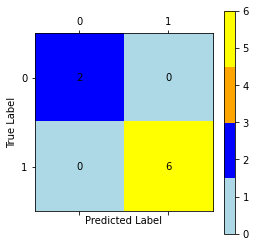

In [11]:
evaluate_model_performance(base_model,test_data_generator)

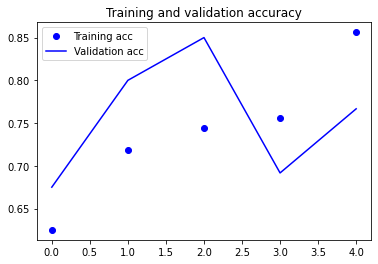

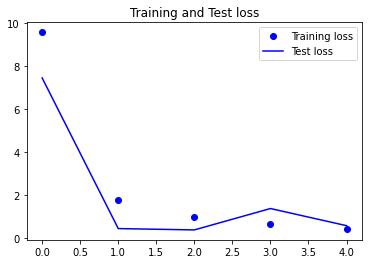

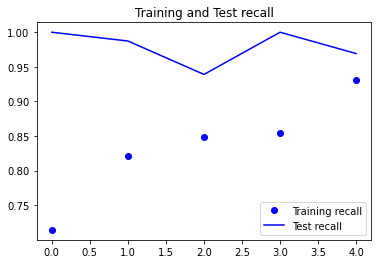

In [12]:
visualize_training(base_model_results,"")

## Sophisticating model architecture

Before exploring tuning and optimization of hyperparameters and other methods such as regularization, we will sophisticate the architectuer of the model itself by incorporating more layers in a variety of types including convolutional layers, pooling layers, and dense layers. 

In [13]:
deep_model = models.Sequential()

deep_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Flatten())
deep_model.add(layers.Dense(512, activation='relu'))
deep_model.add(layers.Dense(256, activation='relu'))
deep_model.add(layers.Dense(1, activation='sigmoid'))

deep_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [14]:
deep_model_results = deep_model.fit(train_data_generator, 
                              steps_per_epoch=20, 
                              epochs=5, 
                              validation_data=test_data_generator, 
                              validation_steps=15)

Epoch 1/5
20/20 [==============================] - 7s 352ms/step - loss: 0.8677 - acc: 0.7312 - recall_1: 0.9350 - val_loss: 0.6707 - val_acc: 0.5917 - val_recall_1: 1.0000
Epoch 2/5
20/20 [==============================] - 6s 317ms/step - loss: 0.5312 - acc: 0.7937 - recall_1: 0.9531 - val_loss: 0.8431 - val_acc: 0.6083 - val_recall_1: 1.0000
Epoch 3/5
20/20 [==============================] - 6s 320ms/step - loss: 0.5003 - acc: 0.7750 - recall_1: 0.9435 - val_loss: 0.7473 - val_acc: 0.6500 - val_recall_1: 1.0000
Epoch 4/5
20/20 [==============================] - 6s 322ms/step - loss: 0.5878 - acc: 0.7688 - recall_1: 0.9298 - val_loss: 0.4344 - val_acc: 0.7833 - val_recall_1: 0.6667
Epoch 5/5
20/20 [==============================] - 7s 328ms/step - loss: 0.4888 - acc: 0.7937 - recall_1: 0.8621 - val_loss: 0.4842 - val_acc: 0.8167 - val_recall_1: 0.9740


In [15]:
deep_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

The more complex model architecture seems to have worsened performance overall, my analysis is that the model is overfitting so regularization is the most appropriate next steps. 

1/1 [==============================] - 0s 2ms/step - loss: 0.8973 - acc: 0.7500 - recall_1: 0.8333
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         2
         1.0       0.83      0.83      0.83         6

    accuracy                           0.75         8
   macro avg       0.67      0.67      0.67         8
weighted avg       0.75      0.75      0.75         8



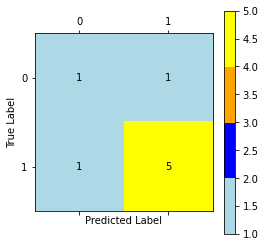

In [16]:
evaluate_model_performance(deep_model,test_data_generator)

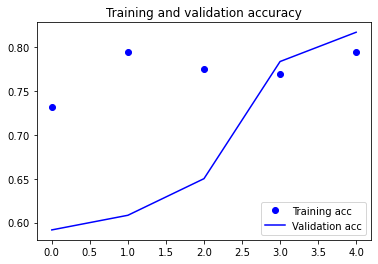

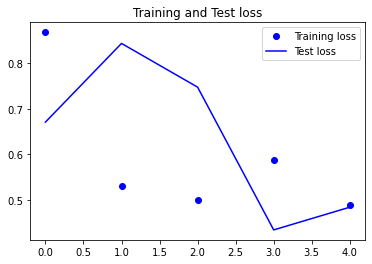

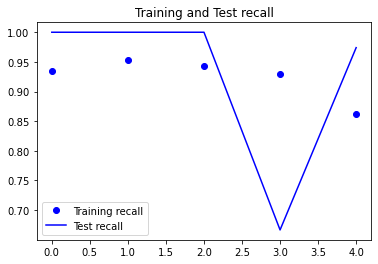

In [17]:
visualize_training(deep_model_results,"_1")

## sophisticating the training protocol

The next step I will take is sophisticating the parameters of the fit function being used. My intuition is that the fit function is too simple relative to the complexity of the model architecture. 

In [18]:
fitter_model_results = deep_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

Epoch 1/15
50/50 [==============================] - 15s 308ms/step - loss: 0.3121 - acc: 0.8900 - recall_1: 0.9367 - val_loss: 0.5059 - val_acc: 0.8050 - val_recall_1: 0.9672
Epoch 2/15
50/50 [==============================] - 15s 308ms/step - loss: 0.2532 - acc: 0.9125 - recall_1: 0.9430 - val_loss: 0.6963 - val_acc: 0.6450 - val_recall_1: 0.4215
Epoch 3/15
50/50 [==============================] - 16s 317ms/step - loss: 0.2289 - acc: 0.9225 - recall_1: 0.9340 - val_loss: 2.3709 - val_acc: 0.6850 - val_recall_1: 1.0000
Epoch 4/15
50/50 [==============================] - 18s 357ms/step - loss: 0.2182 - acc: 0.9225 - recall_1: 0.9359 - val_loss: 0.5507 - val_acc: 0.8000 - val_recall_1: 0.9672
Epoch 5/15
50/50 [==============================] - 21s 420ms/step - loss: 0.2295 - acc: 0.9150 - recall_1: 0.9286 - val_loss: 0.4422 - val_acc: 0.7850 - val_recall_1: 0.9773
Epoch 6/15
50/50 [==============================] - 24s 483ms/step - loss: 0.1611 - acc: 0.9525 - recall_1: 0.9625 - val_loss

The accuracy and loss on training data is begining to behave more as desired; however on the test data the history is still quite eratic indicating that the model is still overfitting and not able to generalize consistently. All that considered the final accuracy on the training data is the best so far so we're moving in the right direction.

1/1 [==============================] - 0s 2ms/step - loss: 1.4813 - acc: 0.7500 - recall_1: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.71      1.00      0.83         5

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8



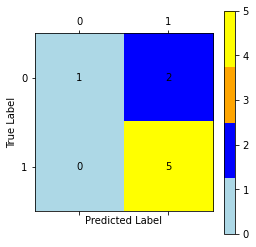

In [19]:
evaluate_model_performance(deep_model,test_data_generator)

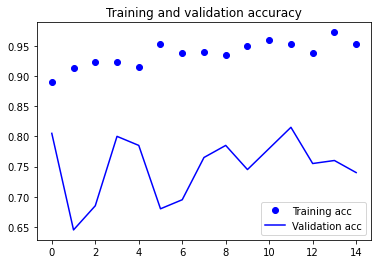

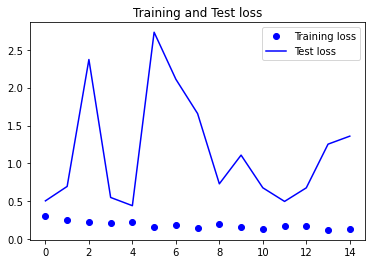

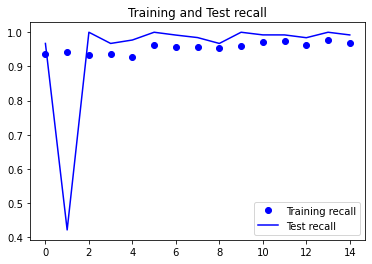

In [20]:
visualize_training(fitter_model_results,"_1")

## Network Regularization

### L2 regularization
I will begin regularizing the network by incorporating L2 regularization on the dense layers of the existing model architecture

In [21]:
from keras.regularizers import l2

In [22]:

L2_model = models.Sequential()

L2_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Flatten())
L2_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(1, activation='sigmoid'))

L2_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [23]:
# added 5 epochs from the last fit call
L2_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=20, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

Epoch 1/20
50/50 [==============================] - 21s 413ms/step - loss: 2.0060 - acc: 0.7200 - recall_2: 0.9272 - val_loss: 0.9383 - val_acc: 0.7800 - val_recall_2: 0.7692
Epoch 2/20
50/50 [==============================] - 23s 454ms/step - loss: 0.7873 - acc: 0.8325 - recall_2: 0.9327 - val_loss: 0.8211 - val_acc: 0.7450 - val_recall_2: 0.9104
Epoch 3/20
50/50 [==============================] - 23s 458ms/step - loss: 0.5258 - acc: 0.8925 - recall_2: 0.9381 - val_loss: 0.6805 - val_acc: 0.7400 - val_recall_2: 0.9375
Epoch 4/20
50/50 [==============================] - 24s 483ms/step - loss: 0.4389 - acc: 0.8900 - recall_2: 0.9329 - val_loss: 0.8967 - val_acc: 0.7400 - val_recall_2: 0.9921
Epoch 5/20
50/50 [==============================] - 28s 552ms/step - loss: 0.3957 - acc: 0.9250 - recall_2: 0.9688 - val_loss: 0.8505 - val_acc: 0.7050 - val_recall_2: 1.0000
Epoch 6/20
50/50 [==============================] - 28s 563ms/step - loss: 0.3492 - acc: 0.9275 - recall_2: 0.9604 - val_loss

In [24]:
L2_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36992)            

L2 regularization appears to have addressed overfitting at least as far a recall is concerned. The recall is nearly perfect, however the validation loss is very high, considering this alongside that validation accuracy tends to be lower than desired, my interpretation is that the model is predicting almost all true positive cases, while also making a considrable amount of false positive predictions. This is more or less the behaviour I am looking for and is consistent with standards in the medical AI industry. The recall is well within an acceptable margin; in the interest of the end user however (i.e. the medical profesionals) I want to reduce the rate of false positives. This would reduce the amount of manual human effort required to validate diagnoses made by the model saving both time and money for both patients and service providers.  

1/1 [==============================] - 0s 2ms/step - loss: 0.5994 - acc: 0.8750 - recall_2: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         2
         1.0       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8



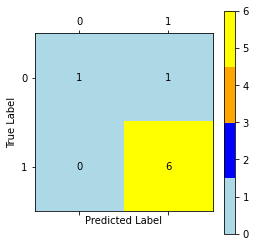

In [25]:
evaluate_model_performance(L2_model,test_data_generator)

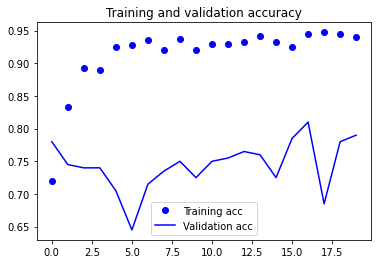

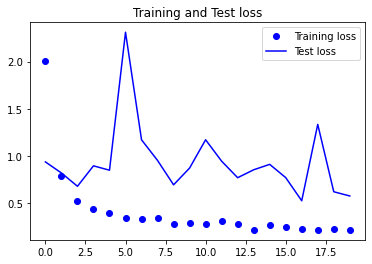

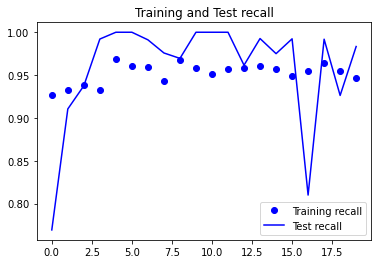

In [26]:
visualize_training(L2_model_results,"_2")

### Dropout regularization
The most common practice with dropout regularization of CNNs is including a dropout layer after each fully connected (Dense) layer. So the next step will be adding two dropout layers each with a value of 0.3, after each of the two hidden Dense layers. There will be no dropout incorporated with the output layer.

In [27]:
dropout_model = models.Sequential()

dropout_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Flatten())
dropout_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(1, activation='sigmoid'))

dropout_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [28]:
dropout_model_results = dropout_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=20, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

Epoch 1/20
50/50 [==============================] - 21s 414ms/step - loss: 2.0563 - acc: 0.7275 - recall_3: 0.9696 - val_loss: 1.0582 - val_acc: 0.6300 - val_recall_3: 1.0000
Epoch 2/20
50/50 [==============================] - 20s 393ms/step - loss: 0.8932 - acc: 0.7875 - recall_3: 0.9502 - val_loss: 0.7618 - val_acc: 0.7200 - val_recall_3: 0.9667
Epoch 3/20
50/50 [==============================] - 20s 396ms/step - loss: 0.6170 - acc: 0.8100 - recall_3: 0.9132 - val_loss: 0.7127 - val_acc: 0.6600 - val_recall_3: 0.9593
Epoch 4/20
50/50 [==============================] - 20s 396ms/step - loss: 0.5417 - acc: 0.8275 - recall_3: 0.9069 - val_loss: 0.6971 - val_acc: 0.7950 - val_recall_3: 0.9512
Epoch 5/20
50/50 [==============================] - 20s 409ms/step - loss: 0.4897 - acc: 0.8925 - recall_3: 0.9286 - val_loss: 0.5294 - val_acc: 0.8600 - val_recall_3: 0.9370
Epoch 6/20
50/50 [==============================] - 20s 392ms/step - loss: 0.3649 - acc: 0.9100 - recall_3: 0.9377 - val_loss

In [30]:
dropout_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

Performance on validation data is still quite eradic accross training epochs, and it appears to have probably worsened recall as well as loss. I will continue with the L2 regularization and leave out any dropout layers. 

1/1 [==============================] - 0s 2ms/step - loss: 0.2565 - acc: 0.8750 - recall_3: 0.8333
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



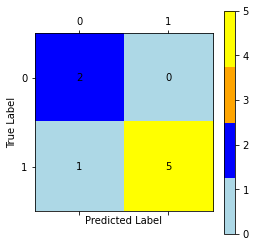

In [31]:
evaluate_model_performance(dropout_model,test_data_generator)

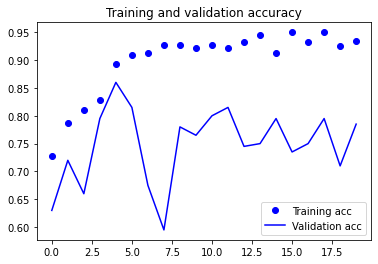

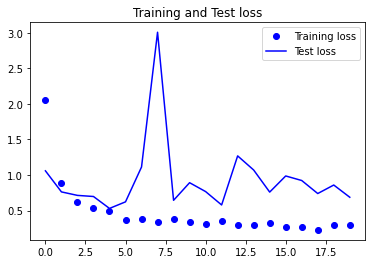

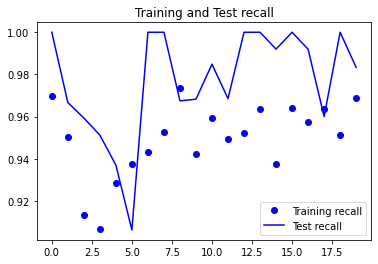

In [32]:
visualize_training(dropout_model_results,"_3")

## Gradient Descent Optimization
So far, a optimizer has not been specified in the model compiler. Below I will test 3 different optimization algorithms, and then will experiment with the learning rate of the best performing algorithm to improve it further. **I will be using a leaner fit function protocol here in the interest of time.**  
The optimizers being test are:
- Stochastic Gradient Descent (SGD)
- Adaptive Moment Estimation (Adam)
- Adaptive Delta (Adadelta)

In [33]:
L2_model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['acc',Recall()])

SGD_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/5
25/25 [==============================] - 7s 292ms/step - loss: 0.2278 - acc: 0.9300 - recall_4: 0.9527 - val_loss: 0.8221 - val_acc: 0.7625 - val_recall_4: 1.0000
Epoch 2/5
25/25 [==============================] - 7s 281ms/step - loss: 0.2167 - acc: 0.9550 - recall_4: 0.9862 - val_loss: 1.1903 - val_acc: 0.7375 - val_recall_4: 1.0000
Epoch 3/5
25/25 [==============================] - 8s 303ms/step - loss: 0.1728 - acc: 0.9550 - recall_4: 0.9655 - val_loss: 1.7540 - val_acc: 0.6625 - val_recall_4: 0.9778
Epoch 4/5
25/25 [==============================] - 9s 349ms/step - loss: 0.3065 - acc: 0.9300 - recall_4: 0.9542 - val_loss: 1.2044 - val_acc: 0.6500 - val_recall_4: 1.0000
Epoch 5/5
25/25 [==============================] - 8s 339ms/step - loss: 0.1805 - acc: 0.9600 - recall_4: 0.9613 - val_loss: 1.1219 - val_acc: 0.7250 - val_recall_4: 0.9792


1/1 [==============================] - 0s 997us/step - loss: 1.6041 - acc: 0.6250 - recall_4: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57         5
         1.0       0.50      1.00      0.67         3

    accuracy                           0.62         8
   macro avg       0.75      0.70      0.62         8
weighted avg       0.81      0.62      0.61         8



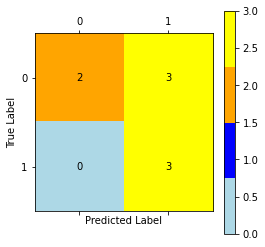

In [34]:
evaluate_model_performance(L2_model,test_data_generator)

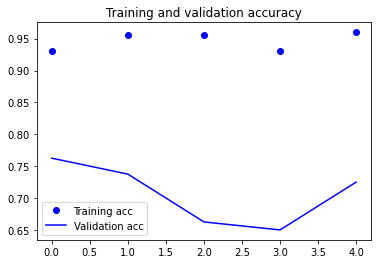

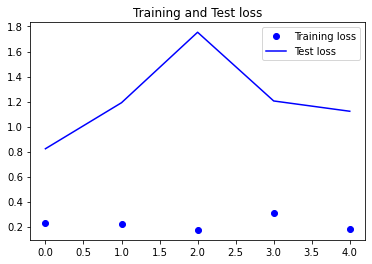

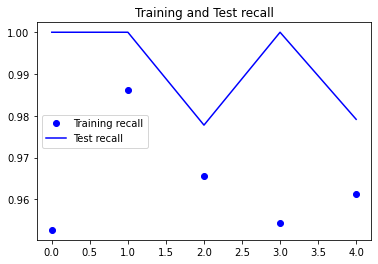

In [35]:
visualize_training(SGD_model_results,"_4")

In [36]:
L2_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

Adam_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/5
25/25 [==============================] - 8s 317ms/step - loss: 0.2355 - acc: 0.9350 - recall_5: 0.9539 - val_loss: 0.9087 - val_acc: 0.7125 - val_recall_5: 0.9574
Epoch 2/5
25/25 [==============================] - 7s 296ms/step - loss: 0.1383 - acc: 0.9650 - recall_5: 0.9815 - val_loss: 0.5023 - val_acc: 0.8375 - val_recall_5: 0.9672
Epoch 3/5
25/25 [==============================] - 8s 302ms/step - loss: 0.1553 - acc: 0.9650 - recall_5: 0.9739 - val_loss: 1.5036 - val_acc: 0.6250 - val_recall_5: 1.0000
Epoch 4/5
25/25 [==============================] - 7s 298ms/step - loss: 0.2896 - acc: 0.9000 - recall_5: 0.9116 - val_loss: 0.9536 - val_acc: 0.6625 - val_recall_5: 0.9787
Epoch 5/5
25/25 [==============================] - 8s 332ms/step - loss: 0.2376 - acc: 0.9350 - recall_5: 0.9510 - val_loss: 0.8656 - val_acc: 0.7500 - val_recall_5: 1.0000


1/1 [==============================] - 0s 987us/step - loss: 0.7653 - acc: 0.7500 - recall_5: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.71      1.00      0.83         5

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8



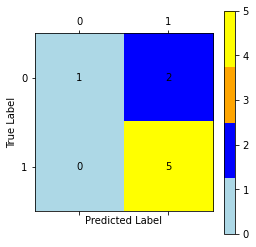

In [37]:
evaluate_model_performance(L2_model,test_data_generator)

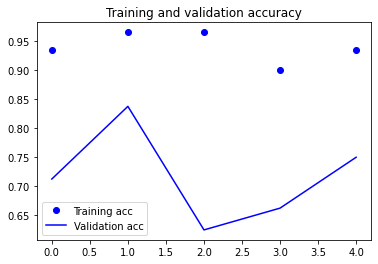

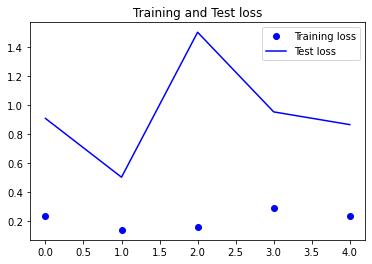

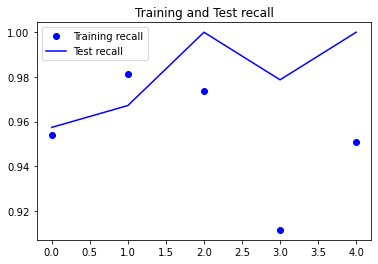

In [38]:
visualize_training(Adam_model_results,"_5")

In [39]:
L2_model.compile(optimizer='Adadelta',
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

Adadelta_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/5
25/25 [==============================] - 9s 340ms/step - loss: 0.1772 - acc: 0.9700 - recall_6: 0.9728 - val_loss: 0.9986 - val_acc: 0.7125 - val_recall_6: 1.0000
Epoch 2/5
25/25 [==============================] - 8s 301ms/step - loss: 0.1644 - acc: 0.9850 - recall_6: 0.9934 - val_loss: 0.7515 - val_acc: 0.7375 - val_recall_6: 1.0000
Epoch 3/5
25/25 [==============================] - 8s 328ms/step - loss: 0.1414 - acc: 0.9950 - recall_6: 0.9929 - val_loss: 0.9210 - val_acc: 0.7125 - val_recall_6: 1.0000
Epoch 4/5
25/25 [==============================] - 9s 358ms/step - loss: 0.1599 - acc: 0.9700 - recall_6: 0.9797 - val_loss: 0.8463 - val_acc: 0.7375 - val_recall_6: 1.0000
Epoch 5/5
25/25 [==============================] - 9s 369ms/step - loss: 0.1984 - acc: 0.9400 - recall_6: 0.9664 - val_loss: 0.6958 - val_acc: 0.7750 - val_recall_6: 1.0000


1/1 [==============================] - 0s 1ms/step - loss: 0.6019 - acc: 0.8750 - recall_6: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         2
         1.0       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8



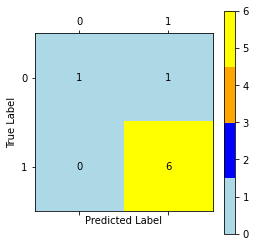

In [40]:
evaluate_model_performance(L2_model,test_data_generator)

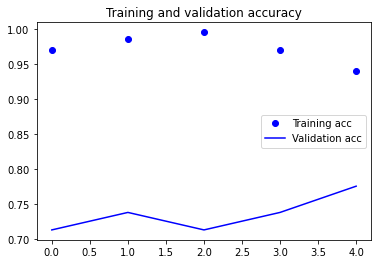

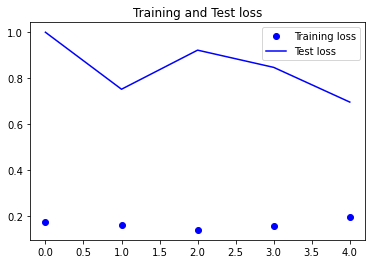

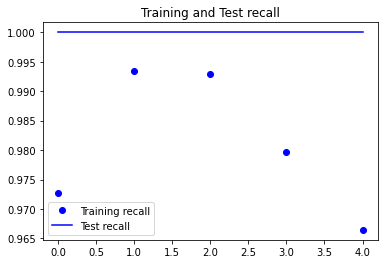

In [41]:
visualize_training(Adadelta_model_results,"_6")

 I am deciding to continue investigating with the Adam optimizer because its loss function has the strongest downward trend among the three, its accuracy continually improves, and the recall although behaving oddly at this point remains within a reasonable range of 1.0 even at its lowest.  

It will be interesting to see how the learning rate affects Adams recall as well how a more robust fit function may help as well. The recall in the above plot seems to decrease over epochs, maybe more epochs are needed or maybe early stoppage would help as well. 

## Learning Rate and Early Stoppage with Adaptive Momentum Optimization

In [42]:
adam_model = models.Sequential()

adam_model.add(layers.Conv2D(8,(3,3),activation='relu',input_shape=(150,150,1)))
adam_model.add(layers.MaxPooling2D((2, 2)))
adam_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
adam_model.add(layers.MaxPooling2D((2, 2)))
adam_model.add(layers.Flatten())
adam_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
adam_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
adam_model.add(layers.Dense(1, activation='sigmoid'))

In [43]:
adam_01 = optimizers.Adam(learning_rate=0.01)
adam_model.compile(optimizer=adam_01,
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [44]:
Adam_01_model_results = adam_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=10, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/10
50/50 [==============================] - 9s 179ms/step - loss: 8.8476 - acc: 0.6575 - recall_7: 0.8597 - val_loss: 1.8785 - val_acc: 0.6500 - val_recall_7: 1.0000
Epoch 2/10
50/50 [==============================] - 9s 171ms/step - loss: 1.2169 - acc: 0.7275 - recall_7: 1.0000 - val_loss: 1.0095 - val_acc: 0.6875 - val_recall_7: 1.0000
Epoch 3/10
50/50 [==============================] - 8s 170ms/step - loss: 0.9046 - acc: 0.7425 - recall_7: 1.0000 - val_loss: 1.0144 - val_acc: 0.6125 - val_recall_7: 1.0000
Epoch 4/10
50/50 [==============================] - 10s 200ms/step - loss: 0.8253 - acc: 0.7500 - recall_7: 1.0000 - val_loss: 0.8748 - val_acc: 0.6625 - val_recall_7: 1.0000
Epoch 5/10
50/50 [==============================] - 10s 202ms/step - loss: 0.7343 - acc: 0.7875 - recall_7: 1.0000 - val_loss: 0.8996 - val_acc: 0.6375 - val_recall_7: 1.0000
Epoch 6/10
50/50 [==============================] - 10s 200ms/step - loss: 0.7601 - acc: 0.7275 - recall_7: 1.0000 - val_loss: 0

In [45]:
adam_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 8)       80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 16)        1168      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               10617344  
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

1/1 [==============================] - 0s 2ms/step - loss: 0.7950 - acc: 0.6250 - recall_7: 1.0000
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.62      1.00      0.77         5

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8



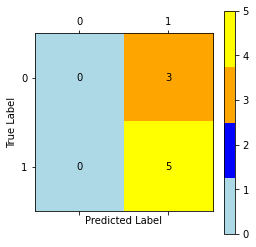

In [48]:
evaluate_model_performance(adam_model,test_data_generator)

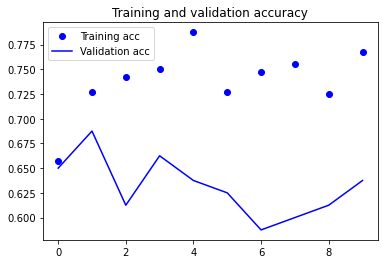

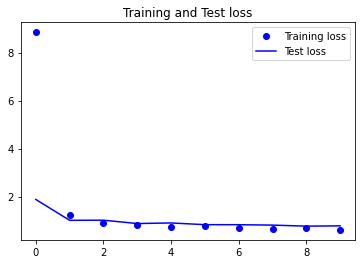

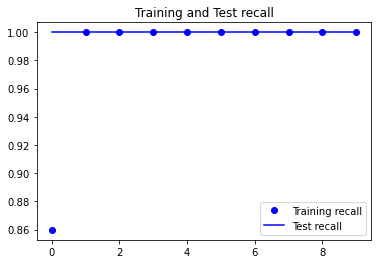

In [47]:
visualize_training(Adam_01_model_results,"_7")

Improving the loss function should reduce the false positive rate, making the tool more effective to the end user. Next I will rerun the above model using early stoppage monitoring the loss function. 

In [49]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [50]:
early_stopping = [EarlyStopping(monitor='val_loss',patience=5),
                  ModelCheckpoint(filepath='data/final_model.h5',monitor='val_loss',save_best_only=True)]

In [51]:
final_model_results = adam_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=50,
                                        callbacks=early_stopping, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/50
50/50 [==============================] - 9s 185ms/step - loss: 0.6310 - acc: 0.7400 - recall_7: 1.0000 - val_loss: 0.7751 - val_acc: 0.5875 - val_recall_7: 1.0000
Epoch 2/50
50/50 [==============================] - 9s 173ms/step - loss: 0.5897 - acc: 0.7650 - recall_7: 1.0000 - val_loss: 0.6992 - val_acc: 0.6625 - val_recall_7: 1.0000
Epoch 3/50
50/50 [==============================] - 8s 167ms/step - loss: 0.5971 - acc: 0.7500 - recall_7: 1.0000 - val_loss: 0.7294 - val_acc: 0.6000 - val_recall_7: 1.0000
Epoch 4/50
50/50 [==============================] - 8s 165ms/step - loss: 0.5521 - acc: 0.7850 - recall_7: 1.0000 - val_loss: 0.8091 - val_acc: 0.6000 - val_recall_7: 1.0000
Epoch 5/50
50/50 [==============================] - 8s 168ms/step - loss: 0.5722 - acc: 0.7600 - recall_7: 1.0000 - val_loss: 0.7179 - val_acc: 0.6125 - val_recall_7: 1.0000
Epoch 6/50
50/50 [==============================] - 9s 173ms/step - loss: 0.6246 - acc: 0.7050 - recall_7: 1.0000 - val_loss: 0.70

1/1 [==============================] - 0s 998us/step - loss: 0.7033 - acc: 0.6250 - recall_7: 1.0000
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.62      1.00      0.77         5

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8



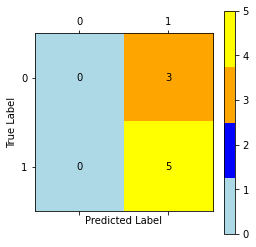

In [52]:
evaluate_model_performance(adam_model,test_data_generator)

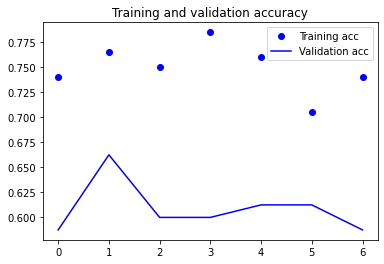

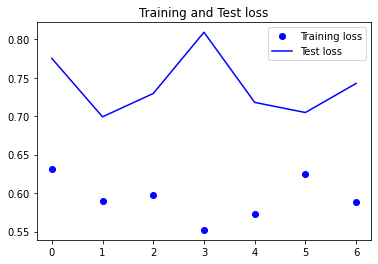

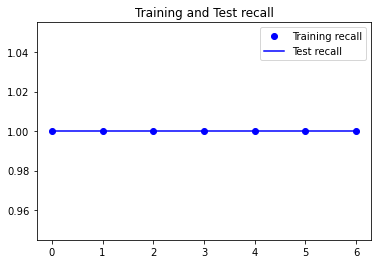

In [53]:
visualize_training(final_model_results,"_7")

# Final Model QA
A final model has been decided on and saved for portability and reusability. Below I am simply loading the model and ensuring its usability as well as confirming it is consistent with its original form (in memory in this notebook).

In [54]:
from keras.models import load_model
saved_model =  load_model('data/final_model.h5')

In [55]:
results_train = saved_model.evaluate(train_data_generator)
print(f'Training Recall: {results_train[2]:.3} \nTraining Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(test_data_generator)
print(f'Test Recall: {results_test[2]:.3} \nTest Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

print('----------')

results_val = saved_model.evaluate(val_data_generator)
print(f'Validation Recall: {results_val[2]:.3} \nValidation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

652/652 [==============================] - 60s 92ms/step - loss: 0.6071 - acc: 0.7429 - recall_7: 1.0000
Training Recall: 1.0 
Training Loss: 0.607 
Training Accuracy: 0.743
----------
78/78 [==============================] - 7s 85ms/step - loss: 0.7421 - acc: 0.6250 - recall_7: 1.0000
Test Recall: 1.0 
Test Loss: 0.742 
Test Accuracy: 0.625
----------
2/2 [==============================] - 0s 49ms/step - loss: 0.8852 - acc: 0.5000 - recall_7: 1.0000
Validation Recall: 1.0 
Validation Loss: 0.885 
Validation Accuracy: 0.5


1/1 [==============================] - 0s 1ms/step - loss: 0.7421 - acc: 0.6250 - recall_7: 1.0000
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.62      1.00      0.77         5

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8



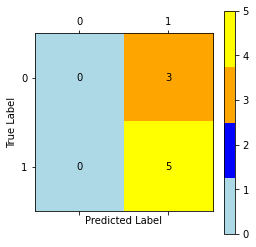

In [57]:
evaluate_model_performance(saved_model,val_data_generator)

## Conclusions
The final model is saved succesfully and performs within the needs of its inteneded use. It has an improvable false positive rate, however it performs well enough that I am comfortable deploying it to beta testing in the real world with select medical offices and begin developing the software through which end users will utilize the tool. While the false positive rate is extant, the false negative rate is minuscule and the true positive rate is almost perfect; this is consistent with other classification methods and AI used for medical diagnostic purposes.
